# 生成式对话机器人

## 简介

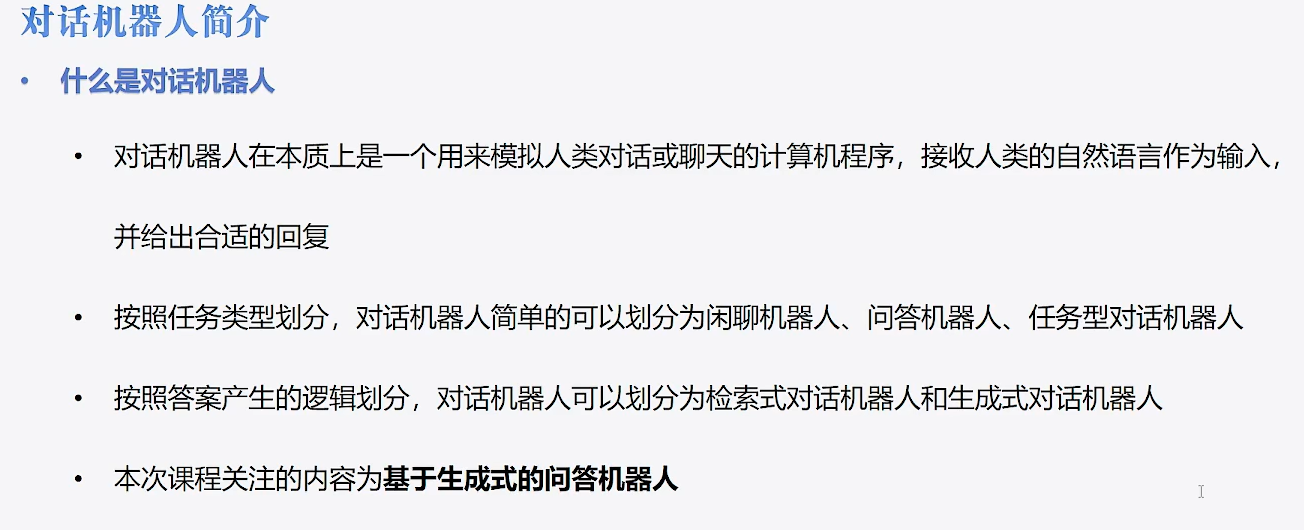

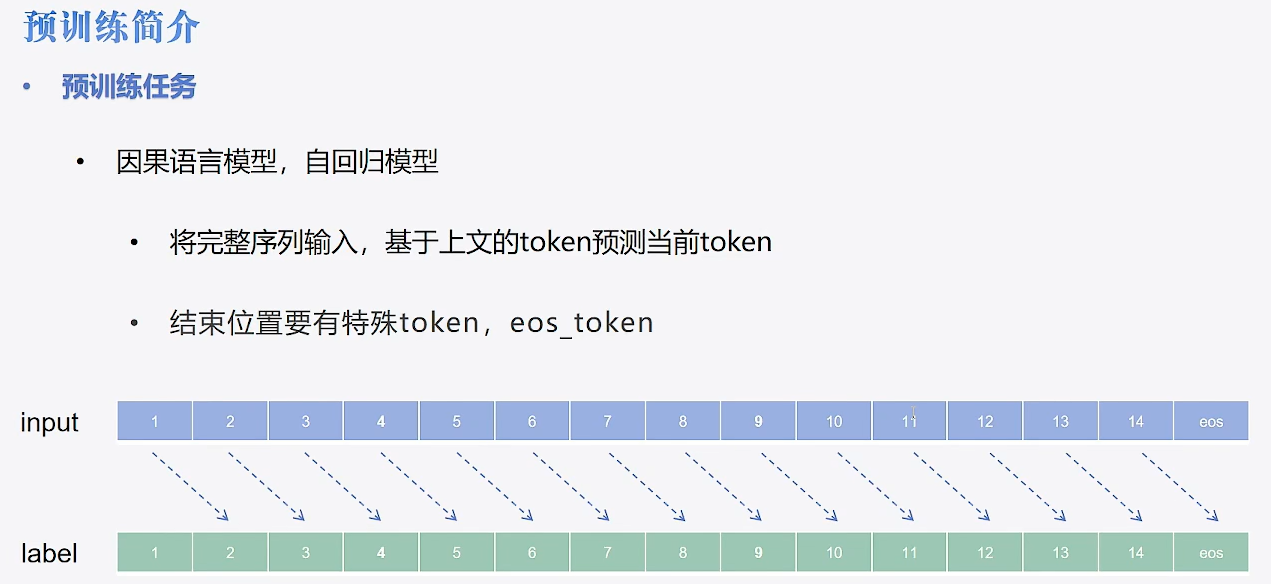

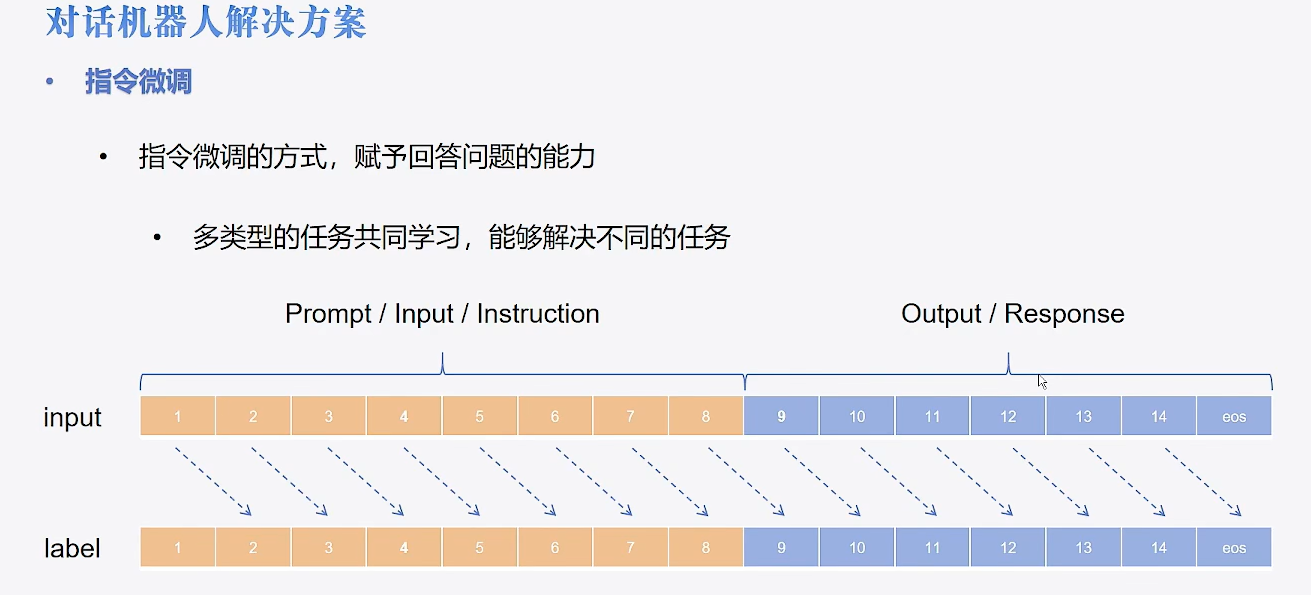

### 1. 单轮问答

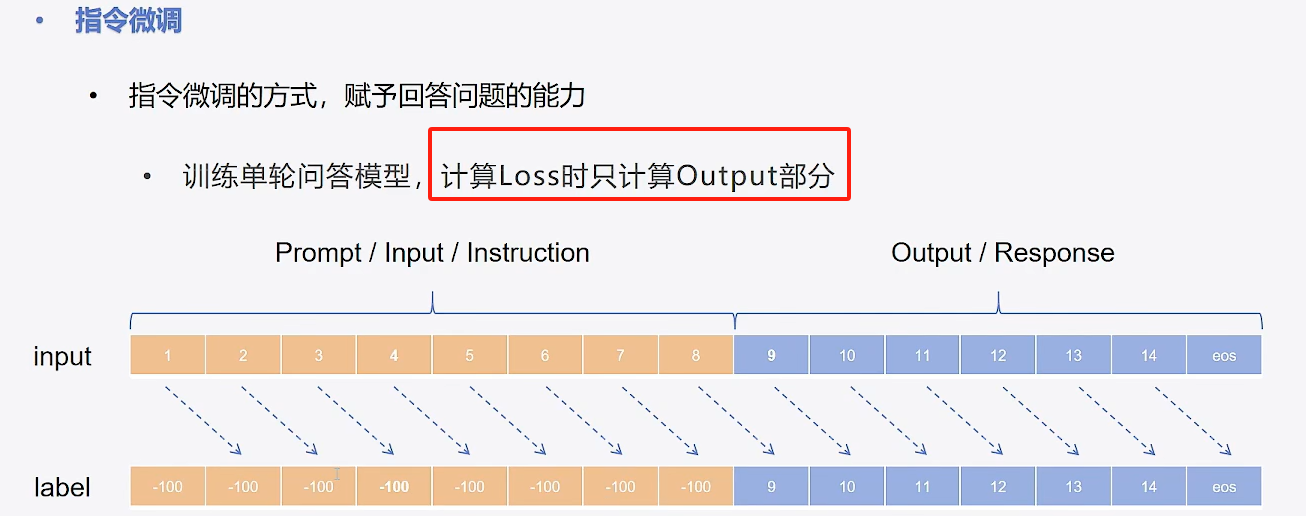

### 2. 多轮问答

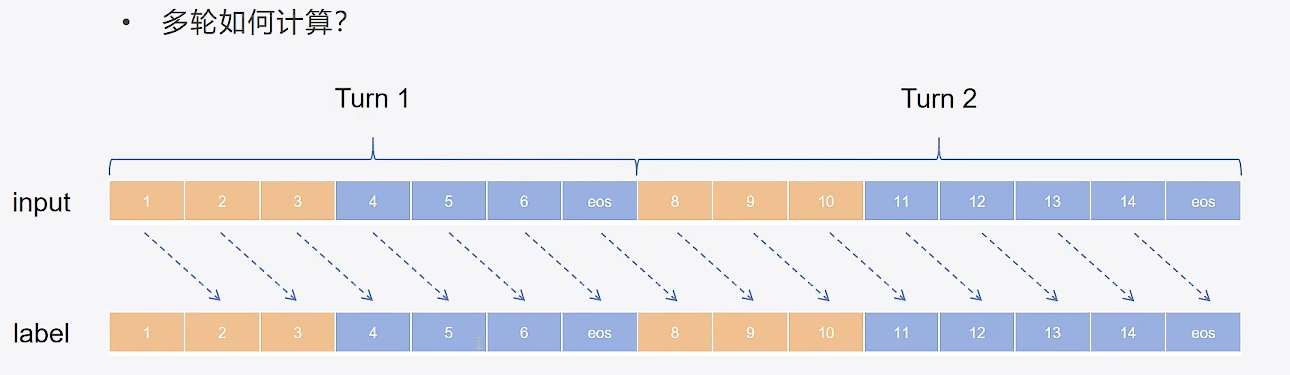

黄色：我们说的话；蓝色：之前的回复。

把前面都拼在一起。

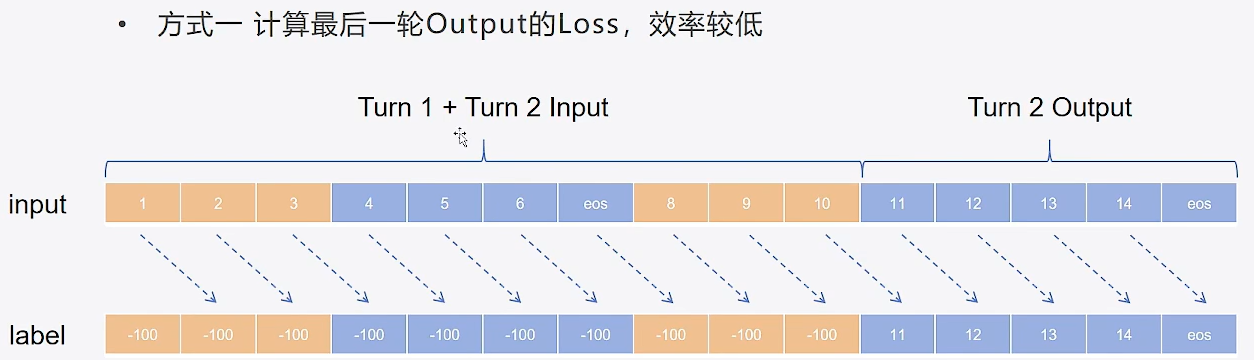

方法1：把整个turn1（人和机器答复）加上turn2人说的话，拼在一起，作为输入，把turn2的output作为输出。

预测的时候，把前面输入都忽视，只计算当前这一轮的输出.

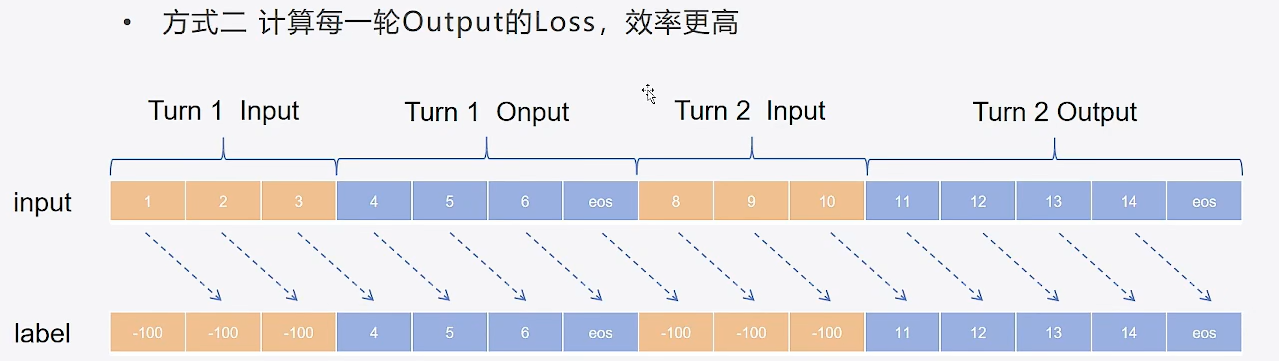

方法2：prompt（输入）就是prompt，输出就是输出。

## 导包

In [1]:
from transformers import BloomTokenizerFast, BloomForCausalLM, AutoTokenizer,AutoModelForCausalLM
from datasets import Dataset
from transformers import Trainer,TrainingArguments,DataCollatorForSeq2Seq
# 不需要做评估，计算Loss就行
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## 预训练模型：Langboat/bloom-389m-zh

In [2]:
# 网站用例
# tokenizer = BloomTokenizerFast.from_pretrained('Langboat/bloom-389m-zh')
# model = BloomForCausalLM.from_pretrained('Langboat/bloom-389m-zh')

# print(tokenizer.batch_decode(model.generate(tokenizer.encode('中国的首都是', return_tensors='pt'))))


In [3]:
tokenizer = AutoTokenizer.from_pretrained('Langboat/bloom-389m-zh')
tokenizer  # BloomForCausalLM

BloomTokenizerFast(name_or_path='Langboat/bloom-389m-zh', vocab_size=42437, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [4]:
model = AutoModelForCausalLM.from_pretrained('Langboat/bloom-389m-zh')

## 加载数据集

In [5]:
datasets = Dataset.load_from_disk('./alpaca_data_zh')
datasets

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [6]:
datasets['output'][0:3]

['以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。',
 '4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。',
 '朱利叶斯·凯撒，又称尤利乌斯·恺撒（Julius Caesar）是古罗马的政治家、军事家和作家。他于公元前44年3月15日被刺杀。 \n\n根据历史记载，当时罗马元老院里一些参议员联合起来策划了对恺撒的刺杀行动，因为他们担心恺撒的统治将给罗马共和制带来威胁。在公元前44年3月15日（又称“3月的艾达之日”），恺撒去参加元老院会议时，被一群参议员包围并被攻击致死。据记载，他身中23刀，其中一刀最终致命。']

In [7]:
datasets['input'][:3]  # 有些问题需要额外的输入

['', '输入：4/16', '']

In [8]:
datasets['instruction'][:3]

['保持健康的三个提示。', '解释为什么以下分数等同于1/4', '朱利叶斯·凯撒是如何死亡的？']

In [9]:
instruction = tokenizer("\n".join(["Human: " + datasets["instruction"][0], datasets["input"][0]]).strip() + "\n\nAssistant: ")
print(instruction)
# eos_token 是 tokenizer 中用于表示序列结束的标记,默认是 [SEP]。所以,这个设置就是指定我们使用 [SEP] 标记来进行补充填充,而不是默认的 [PAD] 标记
res = tokenizer(datasets["output"][0] + tokenizer.eos_token)
print(res)

{'input_ids': [23069, 29, 210, 6583, 24772, 8995, 13533, 671, 189, 4122, 15263, 29, 210], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [4744, 583, 6583, 24772, 8995, 13533, 1022, 189, 189, 20, 17, 210, 6583, 8416, 3228, 420, 8634, 1900, 13648, 8416, 5625, 355, 1202, 29011, 553, 30355, 1298, 15599, 355, 961, 4872, 34650, 5980, 355, 10915, 15342, 7761, 355, 1403, 11472, 6189, 20465, 671, 189, 21, 17, 210, 20122, 13660, 420, 8634, 13869, 20189, 373, 17070, 553, 16382, 553, 1204, 6165, 1430, 641, 14562, 16130, 24251, 15502, 7984, 355, 7981, 1220, 6538, 553, 1220, 14562, 641, 13545, 10249, 355, 714, 6583, 24772, 13660, 11297, 671, 189, 22, 17, 210, 17672, 16272, 420, 17672, 1063, 13966, 5980, 18688, 355, 30645, 8634, 1638, 7900, 954, 3779, 210, 38858, 17672, 420, 14054, 17672, 11472, 15375, 10891, 355, 4872, 8416, 7442, 355, 1403, 5323, 4001, 16885, 14721, 1249, 420, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## 数据预处理

In [10]:
tokenizer(tokenizer.eos_token)

{'input_ids': [2], 'attention_mask': [1]}

In [11]:
def process_func(example):
    input_ids, attention_mask,labels = [],[],[]
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ") # assitant给回复的角色
    response = tokenizer(example['output']+tokenizer.eos_token)
    #  把两段并到一起
    input_ids = instruction["input_ids"]+response['input_ids']
    attention_mask = instruction["attention_mask"]+response['attention_mask']
    labels = [-100]*len(instruction['input_ids'])+response['input_ids']
    # 数据截断
    MAX_LENGTH = 256
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids":input_ids,
        "attention_mask":attention_mask,
        "labels":labels
    }

In [12]:
tokenized_dataset = datasets.map(process_func,remove_columns=datasets.column_names)
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [13]:
tokenizer.decode(tokenized_dataset['input_ids'][0])

'Human: 保持健康的三个提示。\n\nAssistant: 以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。</s>'

In [14]:
# 看labels对不对：
tokenizer.decode(list(filter(lambda x: x!=-100, tokenized_dataset['labels'][0])))

'以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。</s>'

## 训练参数

In [15]:
args = TrainingArguments(
    output_dir="./chatbot",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=2
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 训练器

In [16]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [18]:
trainer.train()

RuntimeError: NCCL Error 1: unhandled cuda error (run with NCCL_DEBUG=INFO for details)

## 模型推理

from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)